Import Libraries

In [ ]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

import matplotlib.pyplot as plt

import time

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

Load Data

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [ ]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Variational Autoencoder

In [ ]:
tf.random.set_seed(42)

codings_size = 10

# Encoder
inputs = tf.keras.layers.Input(shape=[28, 28, 1])
x = tf.keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x = tf.keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(150, activation="relu")(x)
codings_mean = tf.keras.layers.Dense(codings_size)(x)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(x)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [ ]:
# Decoder
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(7 * 7 * 64, activation="relu")(decoder_inputs)
x = tf.keras.layers.Reshape([7, 7, 64])(x)
x = tf.keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", strides=2, padding="same")(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [ ]:
# Connecting encoder and decoder
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [ ]:
# Loss and compilation
latent_loss = -0.5 * tf.reduce_sum(1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean), axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)
variational_ae.compile(loss="mse", optimizer="nadam")

In [ ]:
# Training
history = variational_ae.fit(X_train, X_train, epochs=15, batch_size=128, validation_data=(X_valid, X_valid))


Epoch 1/15
430/430 [==============================] - 52s 112ms/step - loss: 0.0575 - val_loss: 0.0360
Epoch 2/15
430/430 [==============================] - 48s 112ms/step - loss: 0.0345 - val_loss: 0.0340
Epoch 3/15
430/430 [==============================] - 48s 112ms/step - loss: 0.0334 - val_loss: 0.0333
Epoch 4/15
430/430 [==============================] - 47s 109ms/step - loss: 0.0328 - val_loss: 0.0328
Epoch 5/15
430/430 [==============================] - 49s 115ms/step - loss: 0.0324 - val_loss: 0.0325
Epoch 6/15
430/430 [==============================] - 47s 109ms/step - loss: 0.0321 - val_loss: 0.0322
Epoch 7/15
430/430 [==============================] - 48s 112ms/step - loss: 0.0319 - val_loss: 0.0322
Epoch 8/15
430/430 [==============================] - 48s 111ms/step - loss: 0.0317 - val_loss: 0.0320
Epoch 9/15
430/430 [==============================] - 49s 114ms/step - loss: 0.0316 - val_loss: 0.0318
Epoch 10/15
430/430 [==============================] - 49s 115ms/step - l

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

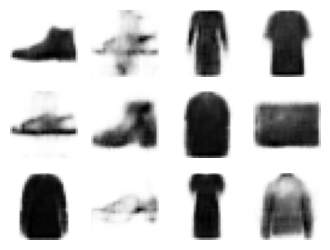

In [ ]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

Deep Convolutional GAN

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 100

generator_d = tf.keras.Sequential([
    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2,
                                    padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2,
                                    padding="same", activation="tanh"),
])
discriminator_d = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
gan_d = tf.keras.Sequential([generator_d, discriminator_d])

In [ ]:
# extra code – compiles the discrimator and the gan, as earlier
discriminator_d.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator_d.trainable = False
gan_d.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [ ]:
# generates the dataset

batch_size = 32
dataset_d = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset_d = dataset_d.shuffle(1000)
dataset_d = dataset_d.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):

    generator, discriminator = gan.layers

    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")

        start = time.time()
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)

            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)

        # print("Epoch {}/{}".format(epoch + 1, n_epochs))
        plot_multiple_images(generated_images, 2)       # <<< "2*8" is number of columns in the plot grid (4*8 = 32 images)
        plt.show()
        delta = time.time() - start
        print(f'Elapsed time: {delta/60} min')

Epoch 1/5


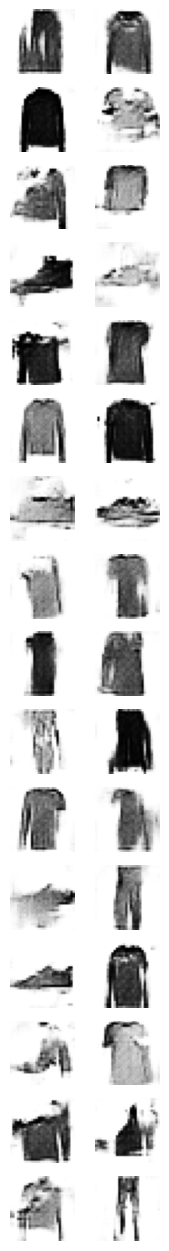

Elapsed time: 8.60348339478175 min
Epoch 2/5


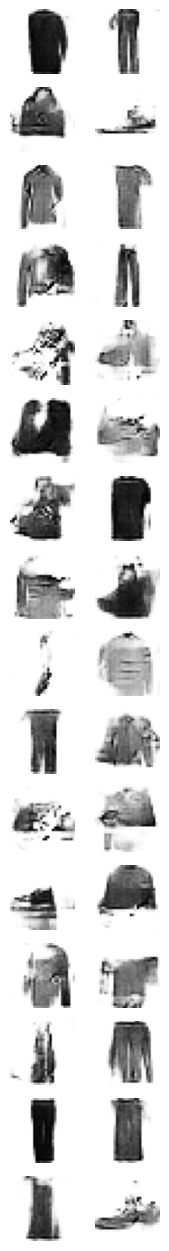

Elapsed time: 8.538172439734142 min
Epoch 3/5


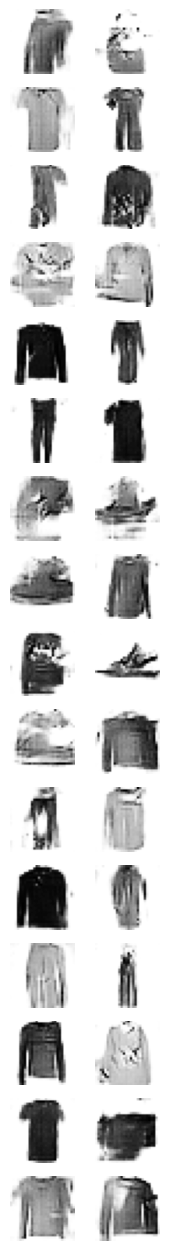

Elapsed time: 8.434743110338847 min
Epoch 4/5


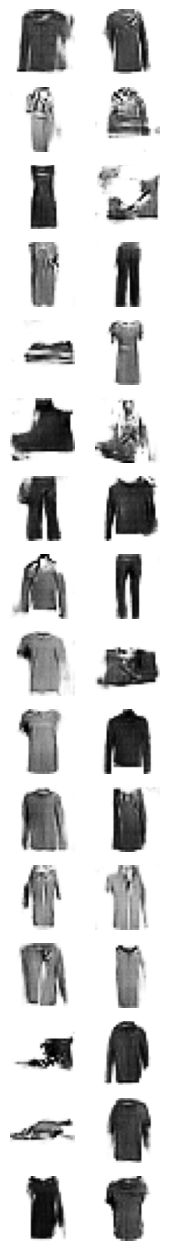

Elapsed time: 8.351317604382833 min
Epoch 5/5


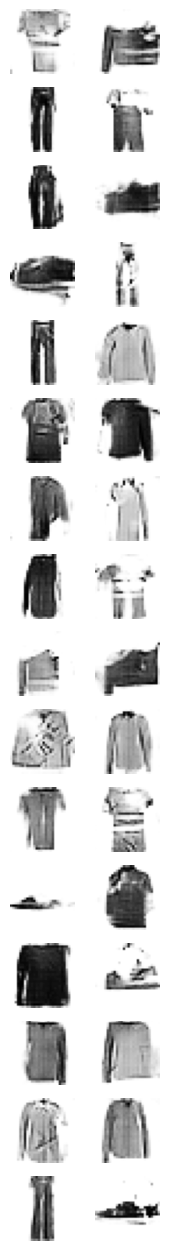

Elapsed time: 8.277013719081879 min


In [ ]:
train_gan(gan_d, dataset_d, batch_size, codings_size, n_epochs=5)

I believe the variational autoencoder did a better job because it was signifcantly faster to train and from the images produced, it looks like it did not hallucinate as much as the DCGAN. It looks like the variational autoencoder produced more blurry pictures but the pictures were clear if it was a boot, shirt, etc. The DCGAN had some pretty signifcant hallicnation as it combined jeans and shirts together into one image and there are many patches in the produced images. Overall, I believe the variational autoencoder did a better job, but it could have been better if I had a larger dataset and more epochs.